In [1]:
import time

def time_algorithm(algorithm, args):
    times = []
    for attemp in [1,2,3]:
        start = time.perf_counter()
        algorithm(*args)
        times.append(time.perf_counter()-start)
    return min(times)

In [2]:
import multiprocessing as mp

def merge_sort(data,left,right):
    '''This is a slighly modified version of the orginal mergeSort code in the slides'''

    # If there is only one element in the list, return the list 
    if right-left<2:
        return data[left:right]
    # Split the list into half
    split = (left+right)//2
    # Iterate the left and right parts of the list
    l = iter(merge_sort(data,left,split))
    r = iter(merge_sort(data,split,right))
    # Create an empty list to store the result after sorting
    result = []
    # Store variables for the first element in left and right sublists
    value_l = next(l)
    value_r = next(r)

    while True:
        # If the first element of the left sublist is smaller 
        if value_l < value_r:
            # Put this element into the sorted result list
            result.append(value_l)
            try:
                # Otherwise, compare the next element
                value_l = next(l)
            except StopIteration:
                # If there are no elements left in the left sublist, append the right sublist to the sorted result list
                return result + [value_r] + list(r)
        else:
            result.append(value_r)
            try:
                value_r = next(r)
            except StopIteration:
                # If there are no elements left in the right sublist, append the left sublist to the sorted result list
                return result + [value_l]+  list(l)

def merge_sort_worker(data,left,right,p):
    '''Create a function for how two parallel workers communicate in the process'''
    if right-left<2:
        p.send(data[left:right]) # Send the result if there is only one element in the list
        return

    split = (left+right)//2

    l = iter(merge_sort(data,left,split))
    r = iter(merge_sort(data,split,right))

    result = []
    value_l = next(l)
    value_r = next(r)

    while True:
        if value_l < value_r:
            result.append(value_l)
            try:
                value_l = next(l)
            except StopIteration:
                # 
                p.send(result + [value_r] + list(r)) # Send the result of right sublists if nothing remains in the left
                return
        else:
            result.append(value_r)
            try:
                value_r=next(r)
            except StopIteration:
                p.send(result + [value_l] + list(l)) # Send the result of left sublists if nothing remains in the right
                return

def merge_sort_parallel(data,left,right):
    ''' Create a function to run the two parallel process'''
    if right-left<2:
        return data[left:right]

    split = (left+right)//2

    # Create two pipes of receivers and senders in p1, p2 processes
    p1_pipe_r,p1_pipe_s = mp.Pipe()
    p2_pipe_r,p2_pipe_s = mp.Pipe()

    # Create two processes: p1 process the left part of the list; p2 process the right part of the list
    p1 = mp.Process(target = merge_sort_worker,args=(data,left,split,p1_pipe_s))
    p2 = mp.Process(target = merge_sort_worker,args=(data,split,right,p2_pipe_s))
    # Start the two processes
    p1.start() 
    p2.start()
    l = iter(p1_pipe_r.recv())
    r = iter(p2_pipe_r.recv())
    # Join the two processes' results 
    p1.join()
    p2.join()

    result = []
    value_l = next(l)
    value_r = next(r)

    while True:
        if value_l<value_r:
            result.append(value_l)
            try:
                value_l = next(l)
            except StopIteration:
                return result + [value_r] + list(r)
        else:
            result.append(value_r)
            try:
                value_r=next(r)
            except StopIteration:
                return result + [value_l] + list(l)

In [6]:
import random 
random.seed(1)
weights = [random.normalvariate(170,30) for patient in range(2**23+1)]
sizes = [2**i for i in range(23)]

# Verify the results by executing single and parallel mergeSort functions 
if __name__ == "__main__":
    single_result = [merge_sort(weights[:size],0,size)for size in sizes]
    parallel_result = [merge_sort_parallel(weights[:size],0,size)for size in sizes]
    print(single_result[5], parallel_result[5])

[132.70190537093285, 138.3648745480729, 140.76116697164156, 143.21750366880315, 144.76057019327982, 145.4623484035526, 152.13960011344216, 158.50610977817166, 159.90629217048075, 163.39965590142563, 163.65976923510826, 169.45340285337033, 169.57323663467645, 170.66164895878202, 171.7760562919656, 171.9573991536012, 176.42788287993696, 177.4024948964072, 178.99564463724212, 184.91123869001987, 188.2236757293112, 194.14956646494218, 196.13372583412666, 200.2415865169108, 200.4644350153141, 202.1020187496404, 206.5244542594982, 206.92721687349982, 208.86840365908287, 209.1701072520559, 209.46867976159746, 221.51910428567862] [132.70190537093285, 138.3648745480729, 140.76116697164156, 143.21750366880315, 144.76057019327982, 145.4623484035526, 152.13960011344216, 158.50610977817166, 159.90629217048075, 163.39965590142563, 163.65976923510826, 169.45340285337033, 169.57323663467645, 170.66164895878202, 171.7760562919656, 171.9573991536012, 176.42788287993696, 177.4024948964072, 178.9956446372

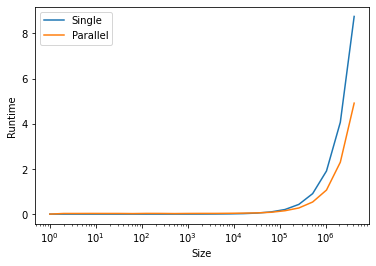

In [7]:
import matplotlib.pyplot as plt

# Compare the runtime in two versions of merge_sort
times_single = [time_algorithm(merge_sort,(weights[:size],0,size)) for size in sizes]
times_parallel = [time_algorithm(merge_sort_parallel,(weights[:size],0,size)) for size in sizes]

plt.plot(sizes, times_single)
plt.plot(sizes, times_parallel)

plt.ylabel('Runtime')
plt.xlabel('Size')
plt.xscale("log")
plt.yscale("linear")
plt.legend(['Single','Parallel'],loc='upper left')
plt.show()